# Downloding Dataset from kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricardosalvatorelli1/paddydoctor")

print("Path to dataset files:", path)


100%|██████████| 1.02G/1.02G [00:46<00:00, 23.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1


# Data spliting

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
dataset_dir = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'
output_dir = 'split_dataset'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Create directories for split dataset
def create_dir_structure():
    for split_dir in [train_dir, val_dir, test_dir]:
        os.makedirs(split_dir, exist_ok=True)

# Split dataset
def split_dataset():
    create_dir_structure()

    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        # Get all image file paths in the current class folder
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

        # Split data into train (70%), temp (30%)
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)

        # Further split temp into validation (10%) and test (20%)
        val_images, test_images = train_test_split(temp_images, test_size=2/3, random_state=42)

        # Move images to respective directories
        for image in train_images:
            dest_dir = os.path.join(train_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

        for image in val_images:
            dest_dir = os.path.join(val_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

        for image in test_images:
            dest_dir = os.path.join(test_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

# Run the script
if __name__ == '__main__':
    split_dataset()
    print("Dataset successfully split into train, validation, and test sets!")


Dataset successfully split into train, validation, and test sets!


In [ ]:
train_path  = "split_dataset/train/"
test_path  = "split_dataset/test/"
val_path  = "split_dataset/val/"
import glob
from pathlib import Path


print('train images')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

print('val images')
for filepath in glob.glob(val_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")


train images
1115 	 hispa
1234 	 normal
235 	 bacterial_panicle_blight
335 	 bacterial_leaf_blight
1009 	 dead_heart
761 	 tungro
1216 	 blast
266 	 bacterial_leaf_streak
434 	 downy_mildew
675 	 brown_spot
test images
320 	 hispa
354 	 normal
68 	 bacterial_panicle_blight
96 	 bacterial_leaf_blight
289 	 dead_heart
218 	 tungro
348 	 blast
76 	 bacterial_leaf_streak
124 	 downy_mildew
194 	 brown_spot
val images
159 	 hispa
176 	 normal
34 	 bacterial_panicle_blight
48 	 bacterial_leaf_blight
144 	 dead_heart
109 	 tungro
174 	 blast
38 	 bacterial_leaf_streak
62 	 downy_mildew
96 	 brown_spot


In [ ]:
import numpy as np
import pandas as pd
import pickle
import cv2
import os

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
keras.__version__
from psutil import virtual_memory

SEED = 123
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width = 256
height = 256
depth = 3

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

10


# Model initialization

In [ ]:
import os
from keras.models import Model
#from keras.optimizers import Adam
#from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet import MobileNet, preprocess_input
#from keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

#https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
def create_model_mobilenet(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = MobileNet(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)

    output_layer = Dense(n_classes, activation='softmax')(top_model)

#     model.add(Dense(1024))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
#     model.add(Dense(n_classes))
#     model.add(Activation("softmax"))


    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape = (256, 256, 3)

# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
model = create_model_mobilenet(input_shape, n_classes, optim_2, fine_tune=24)
model.summary()

<ipython-input-5-699fa1af2ec5>:27: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNet(include_top=False,


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 128, 128, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 128, 128, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 128, 128, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 128, 128, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 128, 128, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 128, 128, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 129, 129, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 64, 64, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 64, 64, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 64, 64, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 64, 64, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 70,349,002 (268.36 MB)

 Trainable params: 69,246,986 (264.16 MB)

 Non-trainable params: 1,102,016 (4.20 MB)

# Data Loader

In [ ]:
image_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 shear_range=0.2,
                 zoom_range=0.2,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1./255,
                                   validation_split=0.2)

train_generator = image_datagen.flow_from_directory(
    directory = train_path,
    subset='training',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

valid_generator = image_datagen.flow_from_directory(
    directory=val_path,
    subset='validation',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=SEED)

print(train_generator.class_indices)
print(test_generator.samples)

Found 5827 images belonging to 10 classes.
Found 202 images belonging to 10 classes.
Found 2087 images belonging to 10 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
2087


In [ ]:
try:
    from livelossplot.inputs.keras import PlotLossesCallback
except:
    !pip install livelossplot

from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='mobilenet_model.weights.best.keras',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

Model Training

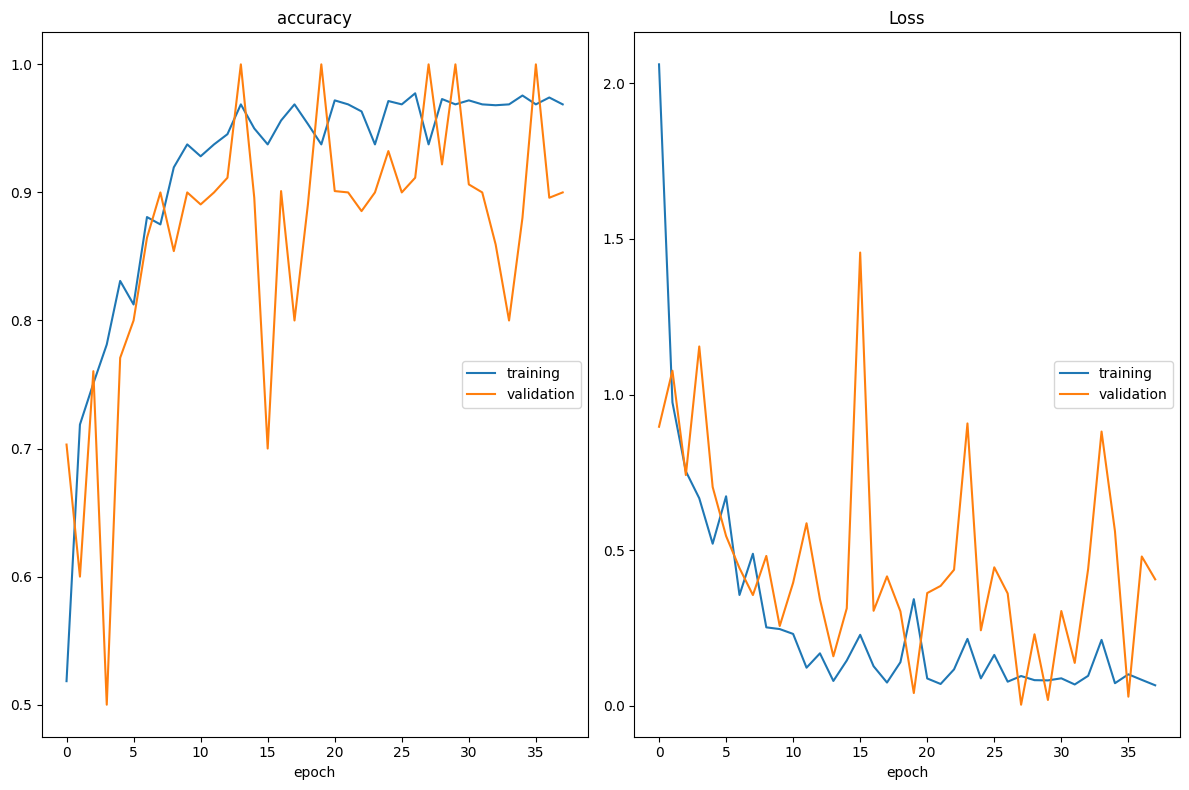

accuracy
	training         	 (min:    0.518, max:    0.977, cur:    0.969)
	validation       	 (min:    0.500, max:    1.000, cur:    0.900)
Loss
	training         	 (min:    0.066, max:    2.061, cur:    0.066)
	validation       	 (min:    0.004, max:    1.456, cur:    0.407)
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.0662 - val_accuracy: 0.9000 - val_loss: 0.4066
CPU times: user 37min 18s, sys: 50.7 s, total: 38min 9s
Wall time: 43min 42s


In [ ]:
%%time

plot_loss_2 = PlotLossesCallback()

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

# Retrain model with fine-tuning
history = model.fit(train_generator,
                                  steps_per_epoch = STEP_SIZE_TRAIN,
                                  validation_data = valid_generator,
                                  validation_steps = STEP_SIZE_VALID,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1,epochs=EPOCHS)

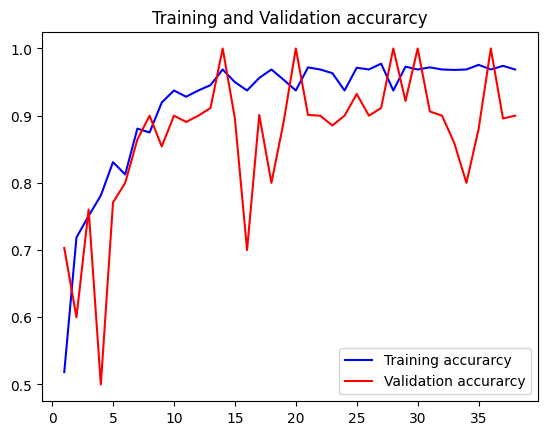

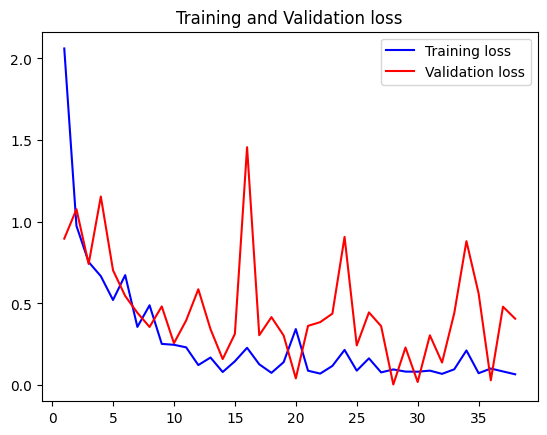

CPU times: user 504 ms, sys: 121 ms, total: 625 ms
Wall time: 635 ms


In [ ]:
%%time
temp = pd.DataFrame(history.history)
temp.to_csv('model_mobilenet_history.csv', index=False)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# Model Testing

In [ ]:
print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    #classes=['.'],
    class_mode="categorical",
    shuffle=False,
    seed=SEED)

test images
320 	 hispa
354 	 normal
68 	 bacterial_panicle_blight
96 	 bacterial_leaf_blight
289 	 dead_heart
218 	 tungro
348 	 blast
76 	 bacterial_leaf_streak
124 	 downy_mildew
194 	 brown_spot
Found 2087 images belonging to 10 classes.


In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

model.load_weights('mobilenet_model.weights.best.keras')
pred = model.predict(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_classes = np.argmax(pred, axis=1)

2087/2087 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator.class_indices.keys()
true_classes = test_generator.classes

acc = accuracy_score(true_classes, pred_classes)
print("mobilenet Model Accuracy : {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes,
                                   target_names=class_names, digits=5)
print(cls_report)

mobilenet Model Accuracy : 90.85%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.87755   0.89583   0.88660        96
   bacterial_leaf_streak    0.96053   0.96053   0.96053        76
bacterial_panicle_blight    0.95082   0.85294   0.89922        68
                   blast    0.87936   0.94253   0.90985       348
              brown_spot    0.93820   0.86082   0.89785       194
              dead_heart    0.98925   0.95502   0.97183       289
            downy_mildew    0.93137   0.76613   0.84071       124
                   hispa    0.86919   0.93437   0.90060       320
                  normal    0.95356   0.87006   0.90990       354
                  tungro    0.81423   0.94495   0.87473       218

                accuracy                        0.90848      2087
               macro avg    0.91641   0.89832   0.90518      2087
            weighted avg    0.91256   0.90848   0.90856      2087



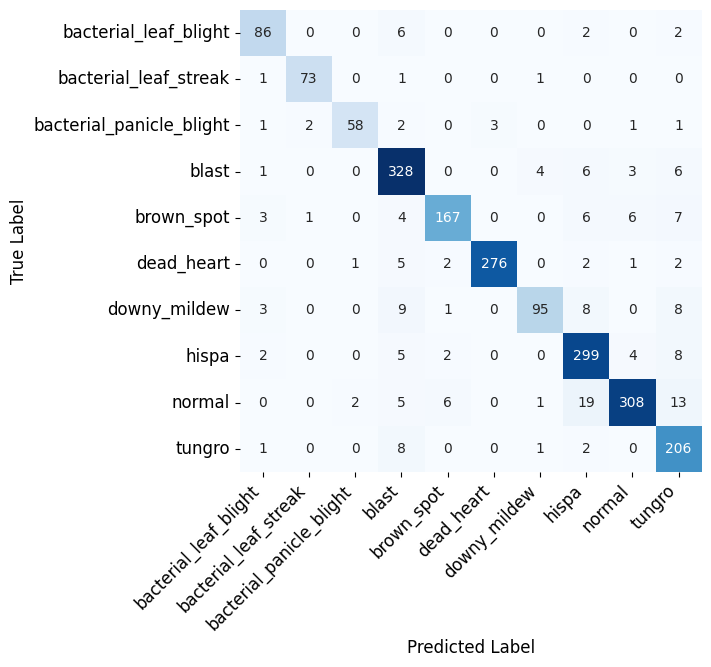

[[ 86   0   0   6   0   0   0   2   0   2]
 [  1  73   0   1   0   0   1   0   0   0]
 [  1   2  58   2   0   3   0   0   1   1]
 [  1   0   0 328   0   0   4   6   3   6]
 [  3   1   0   4 167   0   0   6   6   7]
 [  0   0   1   5   2 276   0   2   1   2]
 [  3   0   0   9   1   0  95   8   0   8]
 [  2   0   0   5   2   0   0 299   4   8]
 [  0   0   2   5   6   0   1  19 308  13]
 [  1   0   0   8   0   0   1   2   0 206]]


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)

In [ ]:
loss, acc = model.evaluate(test_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

2087/2087 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9090 - loss: 0.3882
0.9084810614585876 0.3578718602657318


In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

,count
blast,373
hispa,344
normal,323
dead_heart,279
tungro,253
brown_spot,178
downy_mildew,102
bacterial_leaf_blight,98
bacterial_leaf_streak,76
bacterial_panicle_blight,61


In [ ]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

,image_id,label
0,bacterial_leaf_blight/100133.jpg,bacterial_leaf_blight
1,bacterial_leaf_blight/100268.jpg,bacterial_leaf_blight
2,bacterial_leaf_blight/100330.jpg,blast
3,bacterial_leaf_blight/100382.jpg,tungro
4,bacterial_leaf_blight/100447.jpg,bacterial_leaf_blight
